In [1]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import LiteModels
from Datasets import *

import h5py as h5 
from tqdm import trange
import seaborn as sns
import pandas as pd

from Utils import get_grid

%matplotlib inline

In [2]:
from Datasets import *

seed = 12
noise_std = 0.0
dname = "ring"
p = load_data(dname, D=2, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)
D = p.D
    
plot_size=8
ngrid = 100

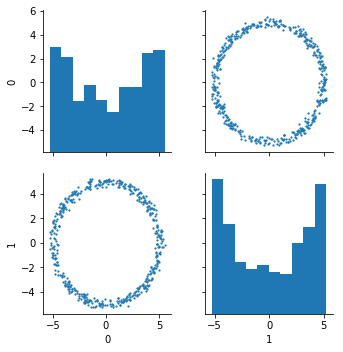

In [4]:
data = p.data[:500,:5]
df = pd.DataFrame(data)
sns.pairplot(df,  plot_kws=dict(s=5, alpha=1.0, linewidth=0))

In [5]:
reload(LiteModels)

<module 'LiteModels' from 'LiteModels.pyc'>

In [ ]:
dl_model = LiteModels.DeepLite(p, npoint=200, nlayer=3, nneuron=15, init_log_lam=-2, init_log_sigma=np.logspace(0,1,1),
                    points_type="opt", step_size=1e-2, base=False, noise_std=0.0, init_weight_std=1.0,
                    niter=1000, ntrain=100, nvalid=100, patience=-1, seed=0,
                    final_ntrain = 100, final_nvalid=200, final_niter = 0, final_step_size=1e-3,
                    gpu_count=1, clip_score=False, curve_penalty=True, add_skip=False)
kernel_res, alpha_res, logZ = dl_model.fit(0)
#dl_model.load()

trainining kernel:  46%|▍| 461/1001 [00:58<01:08,  7.92it/s[{'test': '-11.555', 'loss': '-11.190'}]]

In [23]:
dl_model.estimate_normaliser()

estimating logZ: 100%|█████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.46it/s]


20.729333394296987

In [24]:
ll = dl_model.eval(p.test_data, n=10**7).mean()
print ll
dl_model.fit_alpha(final_niter = 300)
ll = dl_model.eval(p.test_data, n=10**7).mean()
print ll

accumulating stats:   0%|▏                                       | 12/3493 [00:00<00:30, 115.22it/s]

-6.78102650006


fitting lambda: 100%|█████████████████████████████████████████████| 300/300 [00:06<00:00, 43.58it/s]


final validation score: -11.716


estimating logZ: 100%|████████████████████████████████████████████| 100/100 [00:01<00:00, 98.57it/s]

-6.37366248996


/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


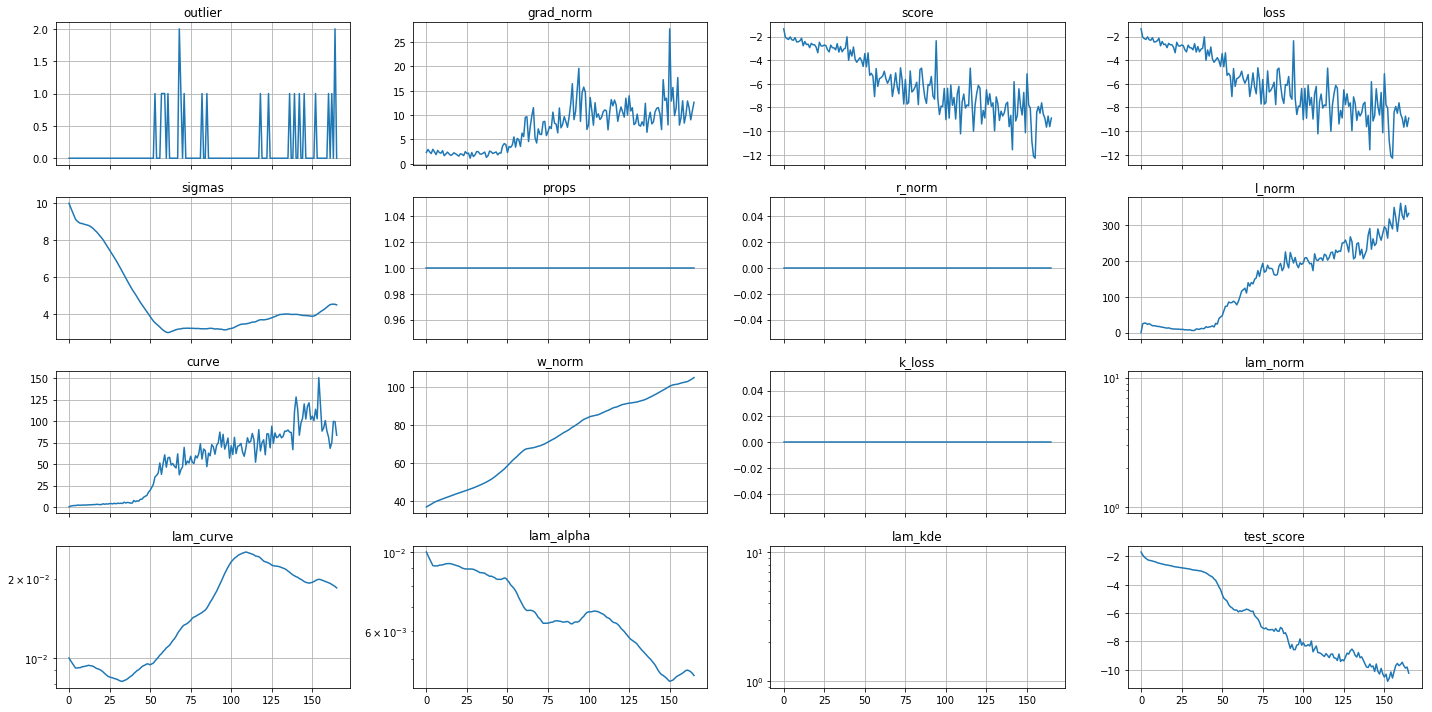

In [25]:
fig, axes = plt.subplots(4,4,figsize=(20,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")

fig.tight_layout()

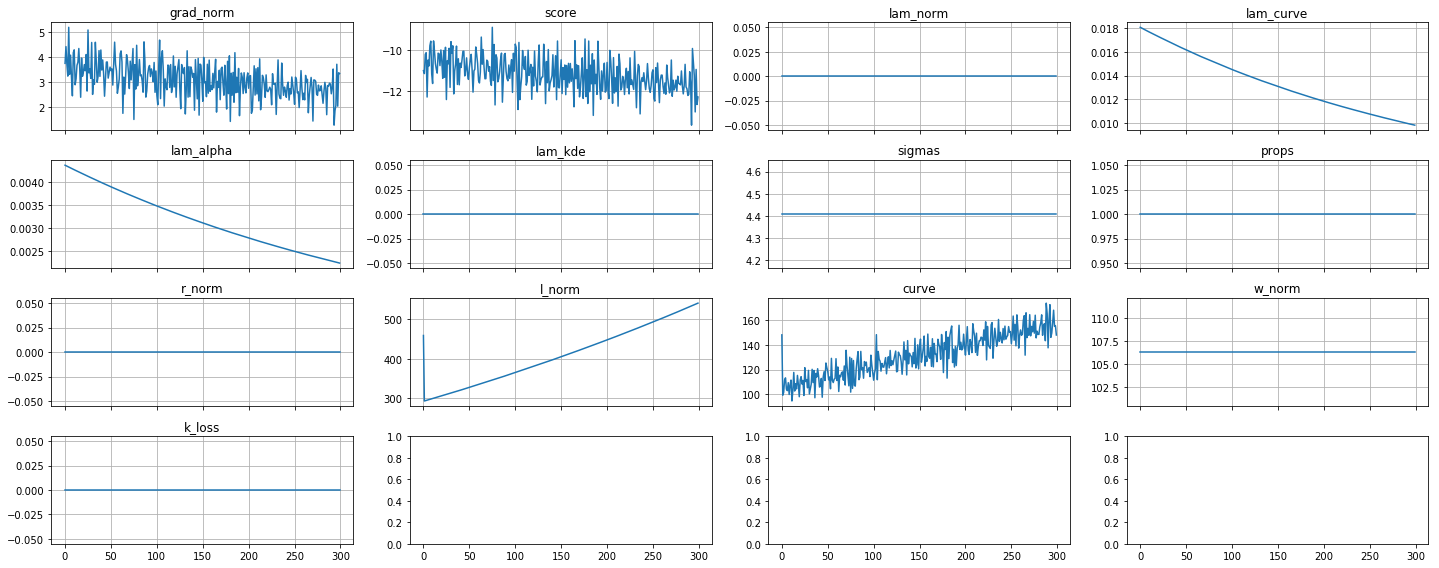

In [26]:
fig, axes = plt.subplots(4,4,figsize=(20,8), sharex=True)
axes = axes.flatten()
res = dl_model.final_state_hist
for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    ax.grid("on")

fig.tight_layout()

(-8.0, 8.0)

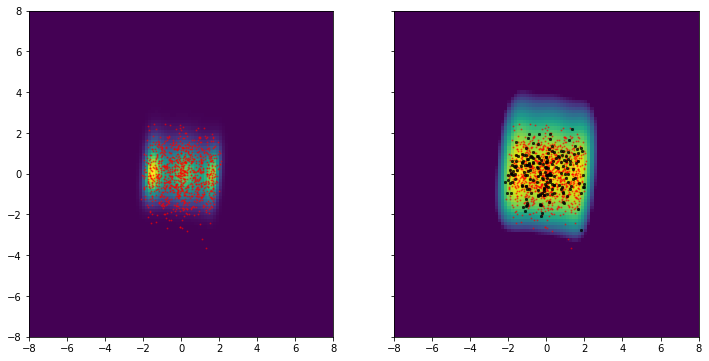

In [27]:
idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


fv = dl_model.fun_multiple(eval_points)
#fv =p.logpdf_multiple(eval_points)

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)


ax = axes[1]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-9)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())

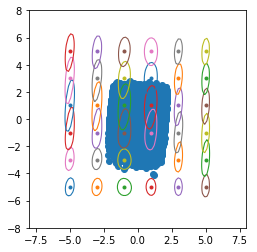

In [28]:
grid_points = get_grid(np.linspace(-5,5,6), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kernel_vals = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})

    for i in range(kernel_vals.shape[0]):
        kv = kernel_vals[i]
        plt.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+1)])
        plt.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
plt.scatter(p.test_data[:,idx_i], p.test_data[:,idx_j])
plt.gca().set_aspect("equal", "box")

In [49]:
maf_model = ex.load_model("maf", mode, [n_hiddens]*2, act_fun, n_layers, True)

In [52]:
maf_model.n_inputs

22

In [ ]:
n_hiddens = 100
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

maf_model = ex.train_maf([n_hiddens]*2, act_fun, n_layers, mode)
#maf_model = ex.load_model("maf", mode, [n_hiddens]*2, act_fun, n_layers, True)
#maf_data_obj = ex.load_data(dname, noise_std=0.0, seed=seed, itanh=False, whiten=True, N=5000)

p.test_data.shape

(174900, 5)

In [70]:
import tensorflow as tf
d1 = tf.constant([0.0,1.0,2.0])
d2 = tf.diag(d1)
d3 = tf.tensordot(d2, I, [[-1],[0]])
with tf.Session() as sess:
    print sess.run(d3)

[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  2.]]]


In [68]:
I1  = tf.eye(3)[None,...]
I2  = tf.eye(3)[:,None,:]
I3  = tf.eye(3)[:,:,None]
I = I1 * I2 * I3
with tf.Session() as sess:
    print sess.run(I)

[[[ 1.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  1.]]]


In [57]:
dl_model.score_multiple(p.test_data).mean()

-11.690316854579796

In [55]:
print maf_model.aapo_score(maf_data_obj.tst.x).mean()

-8.44155


(-5.0, 5.0)

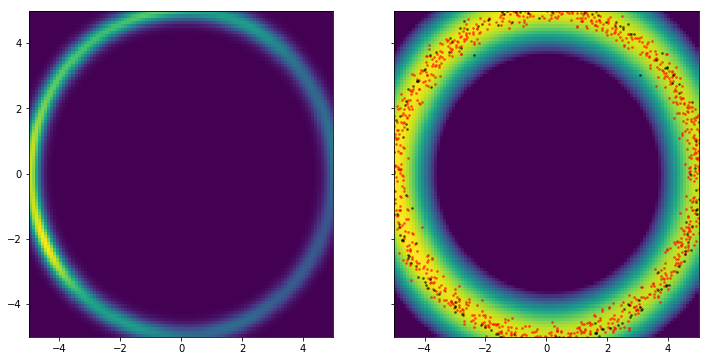

In [16]:
i, j = 0,1

a,b,c = i, j-1-i, p.D-1-j

ngrid = 100
eval_grid = np.linspace(-5,5,ngrid)
'''
imax_loglik = np.argsort(dl_model.estimate_data_lik(p.test_data, batch_size=p_clean.ntest))[:-100]
means = p.test_data[imax_loglik].mean(0)
'''
cond_values = np.zeros(p.D)
epsilon = 0.5

eval_points = np.array([ cond_values[:i].tolist() + [xv] + cond_values[i+1:j].tolist() + [yv] + cond_values[j+1:].tolist() 
    for xv in eval_grid
            for yv in eval_grid])


fv = dl_model.fun_multiple(eval_points)
gv = dl_model.grad_multiple(eval_points)

#fv = p.logpdf_multiple(eval_points)
#gv = p.grad_multiple(eval_points)
#fv = kde.score_samples(eval_points)


gv = gv.reshape(ngrid, ngrid, p.D)
gint = 5


fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid).T)
ax.scatter(p.data[:1000,i], p.data[:1000,j], 1, color="r", alpha=0.0)


ax = axes[1]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid).T, vmin=-15)
ax.scatter(p.data[:1000,i], p.data[:1000,j], 3, color="r", alpha=0.5)
ax.scatter(points_val[:1000,i], points_val[:1000,j], 3, color="k", alpha=0.5, vmin=1)
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(i)
dim.remove(j)
idx_in_range = np.all( (p.data[:,dim]<cond_values[dim]+epsilon) &  (p.data[:,dim]>cond_values[dim]-epsilon), axis=1)
data_in_range = p.data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 1, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())

(-5.0, 5.0)

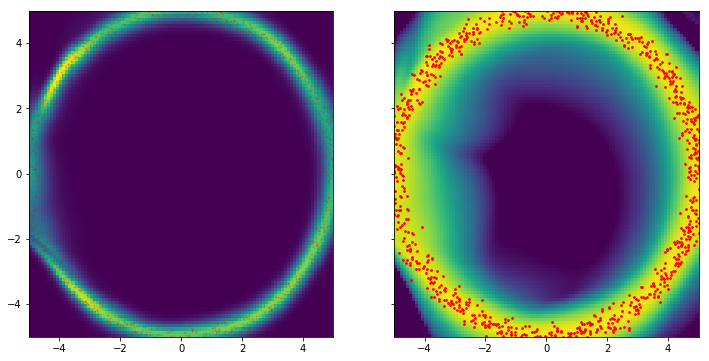

In [17]:
fv = maf_model.eval(eval_points)

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid).T)
ax.scatter(p.data[:1000,i], p.data[:1000,j], 1, color="r", alpha=0.2)


ax = axes[1]
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid).T, vmin=-15)
ax.scatter(p.data[:1000,i], p.data[:1000,j], 3, color="r", alpha=1.0)

dim = range(p.D)
dim.remove(i)
dim.remove(j)
idx_in_range = np.all( (p.data[:,dim]<cond_values[dim]+epsilon) &  (p.data[:,dim]>cond_values[dim]-epsilon), axis=1)
data_in_range = p.data[idx_in_range]
#plt.scatter(data_in_range[:,i], data_in_range[:,j], 1, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())
ax.set_ylim(eval_grid.min(),eval_grid.max())

In [18]:
def plot_samples(x, idx_i, idx_j):
    rn = maf_model.calc_random_numbers(x)
    c = np.arctan2(x[:,0],x[:,1])
    c = c+1.1
    c[c>np.pi]-= 2*np.pi
    c = "r"
    fig, axes = plt.subplots(1,2,figsize=(6,3))

    ax = axes[0]
    ax.scatter(x[:,idx_i], x[:,idx_j], 3, c)
    ax.set_title("data")
    ax = axes[1]
    ax.scatter(rn[:,idx_i], rn[:,idx_j], 3, c)
    ax.set_title("latent")

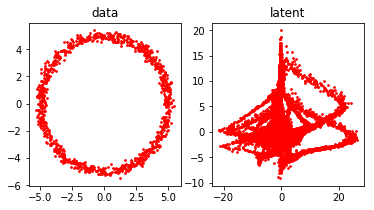

In [19]:
plot_samples(p.test_data, i, j)

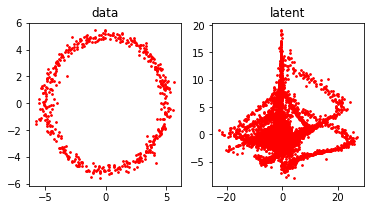

In [21]:
plot_samples(maf_model.gen(500), i, j)

In [39]:
nsample = p.ntest
Madapt = 500
delta = 0.7
thin = 1
nchain = 1

def lnprobfn(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0]


def gradfn(x):
    x = np.atleast_2d(x)
    return dl_model.grad_multiple(x, batch_size=1)[0]

def lnprobgradfun(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0], dl_model.grad_multiple(x, batch_size=1)[0]

samples = []
for i in range(nchain):
    sampler = NUTSSampler(D, lnprobfn, gradfn)
    s = sampler.run_mcmc(np.zeros(p.D), nsample*thin/nchain, Madapt, delta)
    #s, lnprob, epsilon = nuts.nuts6(lnprobgradfun, nsample*thin/nchain, Madapt, np.zeros(p.D), delta)
    samples.append(s[::thin])
samples = np.concatenate(samples, axis=0)

Running HMC with dual averaging and trajectory length 0.70...


nuts sampling:   0%|▏                                               | 3/658 [00:00<00:22, 28.54it/s]

('find_reasonable_epsilon=', 0.25)


nuts sampling: 100%|██████████████████████████████████████████████| 658/658 [00:37<00:00, 17.72it/s]


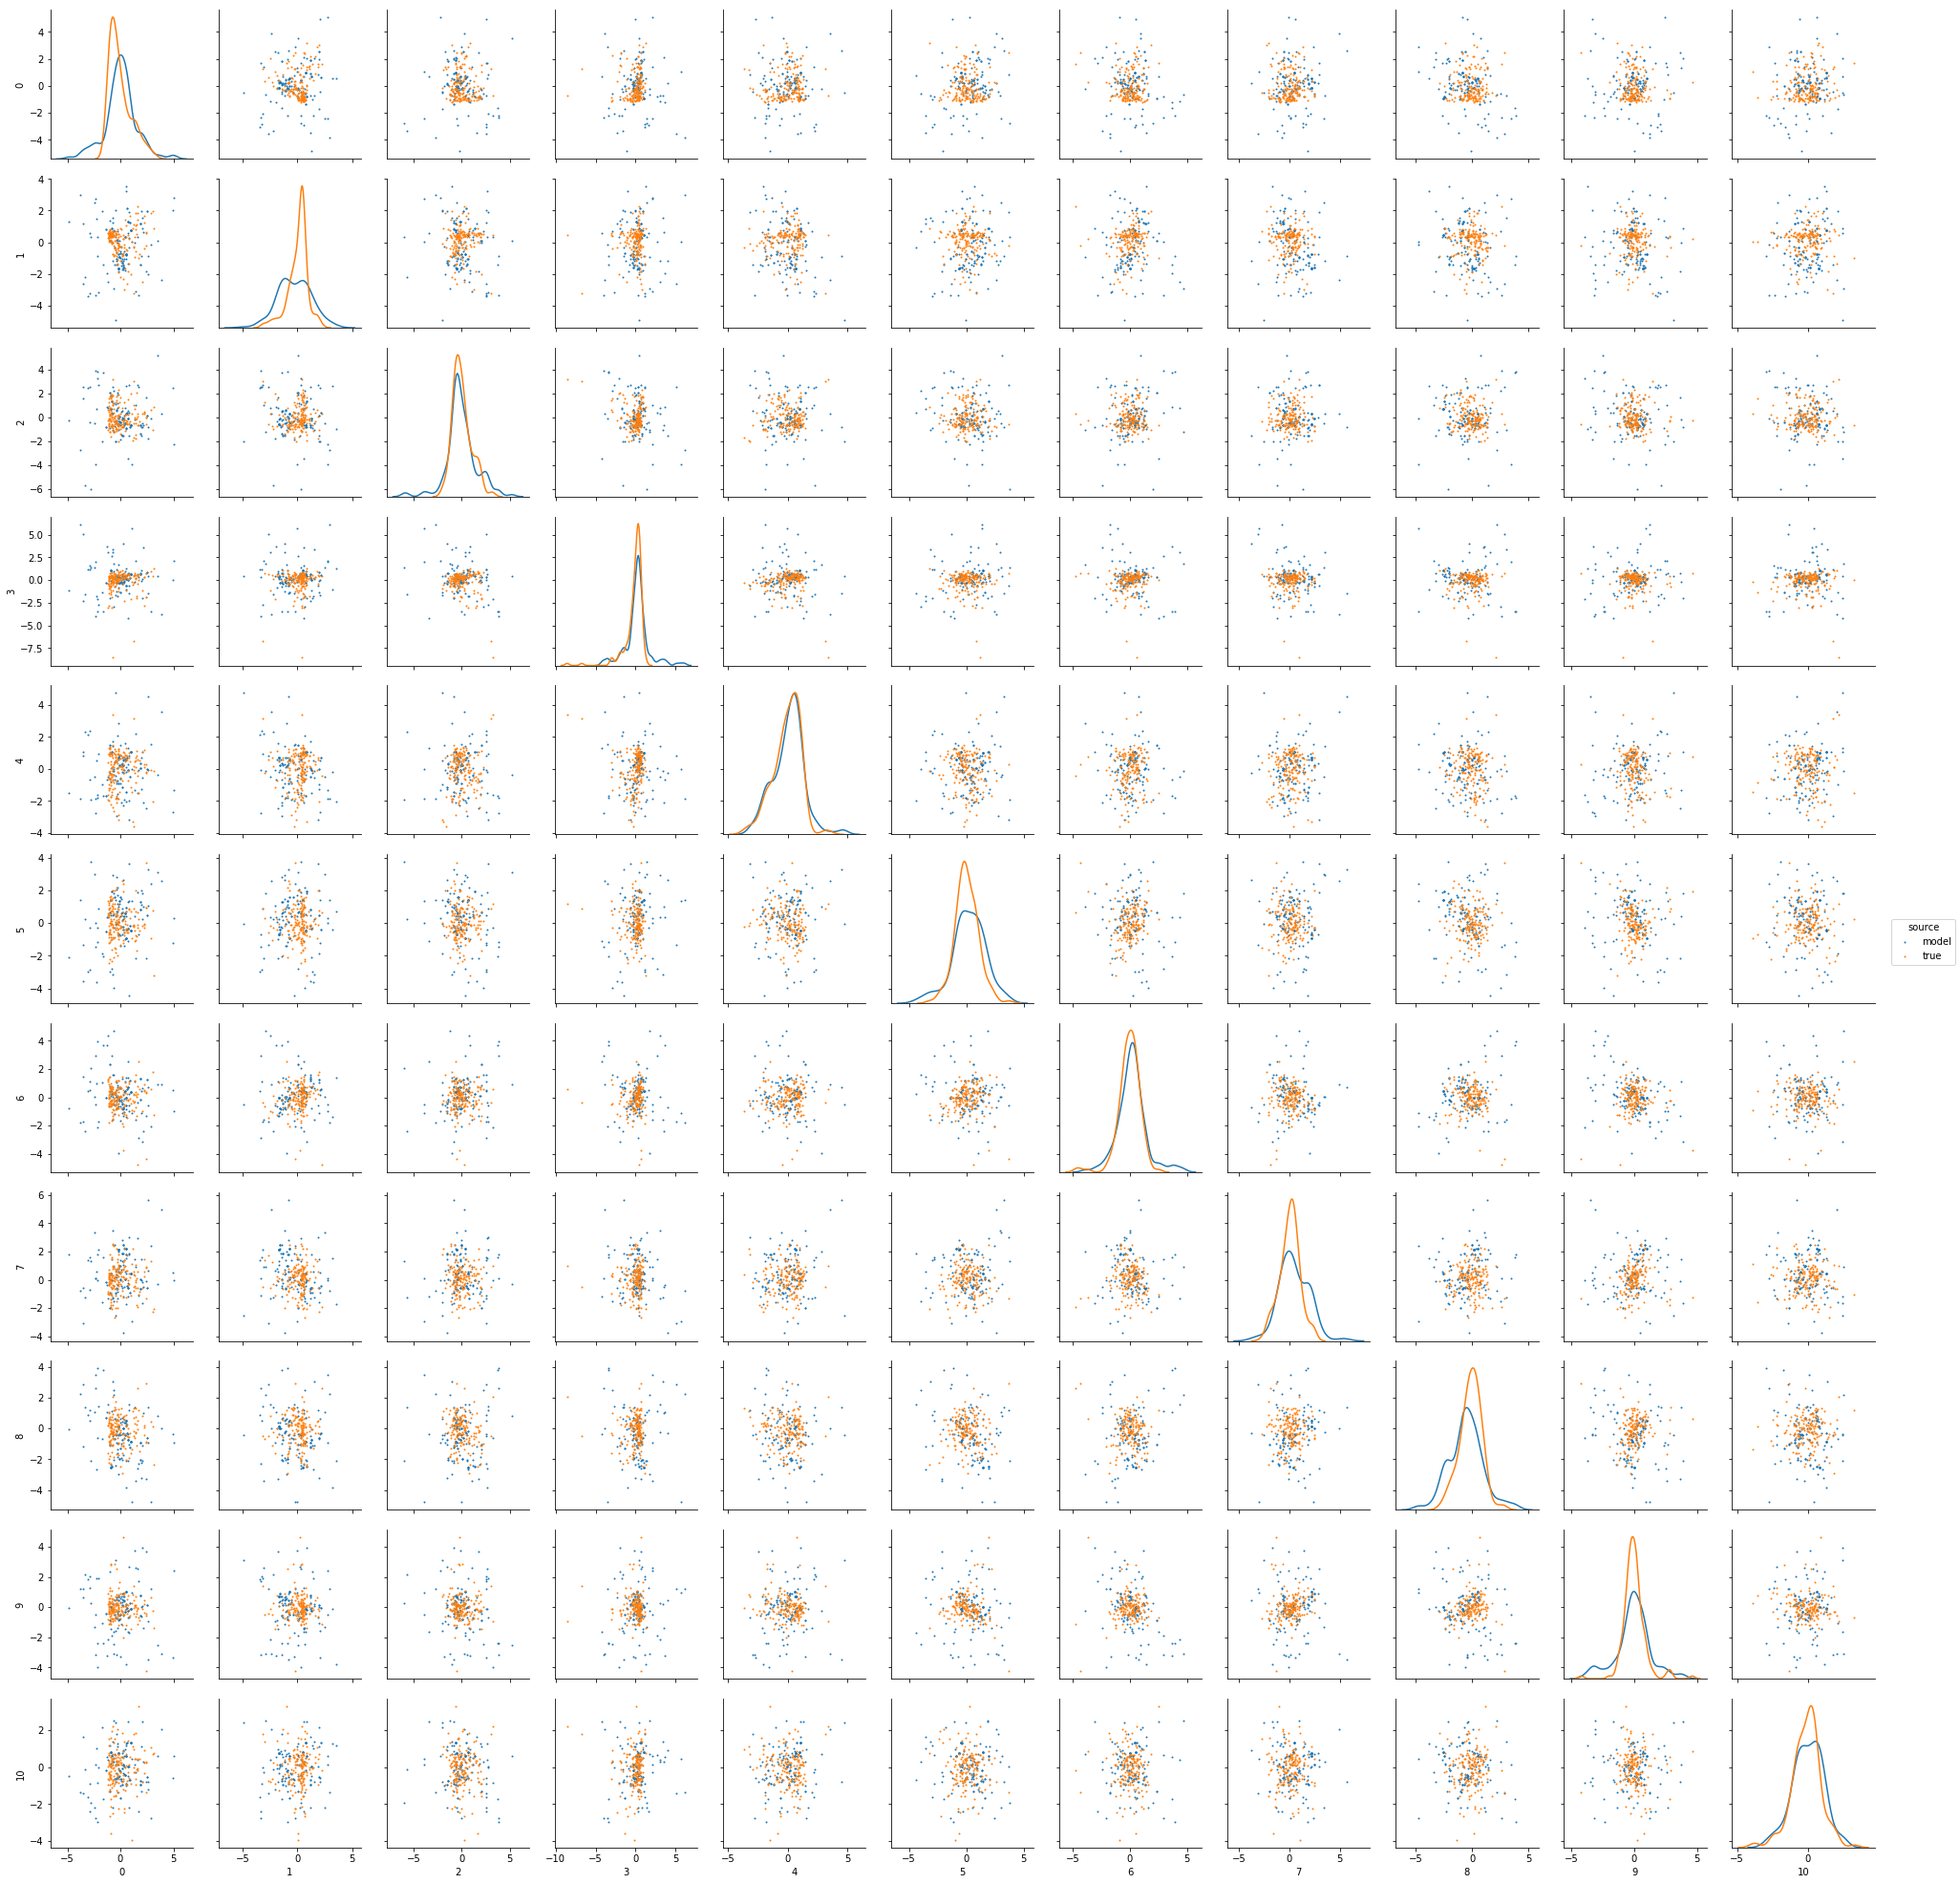

In [41]:
import seaborn as sns
import pandas as pd
perm = np.argsort(p.idx)

model_sample_df = pd.DataFrame(samples[:, :])
model_sample_df["source"] = "model"

true_samples = p.test_data[:nsample]
true_sample_df = pd.DataFrame(true_samples[:, :])
true_sample_df["source"] = "true"

sample_df = pd.concat([model_sample_df, true_sample_df])

fig = sns.pairplot(sample_df, hue="source", size=2.5, diag_kind="kde", kind="scatter",
            plot_kws=dict(s=4, alpha=1.0, linewidth=0),)

#fig.savefig("figs/wine_pairplot.pdf")

In [8]:
from MMD.mmd import MMD_3_Sample_Test
import h5py as h5

model_name = "maf"
other_noise_std = 0.0

if model_name in ["made", "mog_made"]:
    fn = "data/%s/%s_D%02d_n%d_nn100_nt200_p200_%s_samples_s%02d.h5" % (model_name,  p.name, p.D, other_noise_std*100, model_name, seed)
else:
    fn = "data/%s/%s_D%02d_n%d_nn100_nl5_nt200_p200_%s_samples_s%02d.h5" % (model_name,  p.name, p.D, other_noise_std*100, model_name, seed)
with h5.File(fn, "r") as f:

    print f["loglik_noise"].value
    print f["loglik_clean"].value
    
    idx =  f["idx"].value
    assert np.all(idx == p.idx)
    made_samples = f["samples"].value
    made_samples = made_samples
    idx = np.random.choice(made_samples.shape[0] , p.ntest, replace=False)
    
    made_samples = made_samples[idx]

true_samples = p.test_data[:300]

MMD_3_Sample_Test(true_samples, made_samples, samples[:300], computeMMDs=True)

-12.5282830188
-12.5282830188


NameError: name 'samples' is not defined